# TensorFlow for Deep Learning - U-Net for Semantic Segmentation

Credits - [U-Net for Semantic Segmentation](https://www.youtube.com/playlist?list=PLZsOBAyNTZwbR08R959iCvYT3qzhxvGOE/)

<img src="images/TF_UNet1.png" width="700"/>
<img src="images/TF_UNet3.png" width="700"/>


## Data Processing

In [1]:
import os
import numpy as np
from tqdm import tqdm 

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

np.random.seed = 42

IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

TRAIN_PATH = 'data/data-science-bowl-2018/stage1_train/'
TEST_PATH = 'data/data-science-bowl-2018/stage1_test/'

train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)
# counter = 1

print('Resizing training images and masks')
for n, name in tqdm(enumerate(train_ids), total=len(train_ids)):   
    path = TRAIN_PATH + name
    img = imread(path + '/images/' + name + '.png')[:,:,:IMG_CHANNELS]  
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant',  
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)  
    Y_train[n] = mask  
    # counter += 1
    # if counter==100: break

X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

print('Resizing testing images')
for n, name in tqdm(enumerate(test_ids), total=len(test_ids)):   
    path = TEST_PATH + name
    img = imread(path + '/images/' + name + '.png')[:,:,:IMG_CHANNELS]  
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

Resizing training images and masks


100%|██████████| 670/670 [29:15<00:00,  2.62s/it]


Resizing testing images


100%|██████████| 65/65 [00:03<00:00, 17.60it/s]


In [ ]:
from pickle import dump, load

dump(X_train, TRAIN_PATH+'X_train.pkl')
dump(Y_train, TRAIN_PATH+'Y_train.pkl')
dump(X_test, TRAIN_PATH+'X_test.pkl')

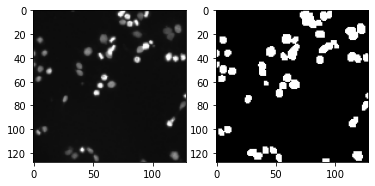

In [2]:
fig, ax = plt.subplots(nrows=1, ncols=2)

ax[0].imshow(X_train[5])
ax[1].imshow(Y_train[5], cmap='gray');

## U-Net Model

In [15]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, concatenate, MaxPool2D, Lambda, Dropout

inputs = Input(shape=(IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))
s = Lambda(lambda x: x/255.)(inputs)

# Contraction Path
c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = Dropout(0.1)(c1)
c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name='c1')(c1)
p1 = MaxPool2D((2, 2))(c1)

c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = Dropout(0.1)(c2)
c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name='c2')(c2)
p2 = MaxPool2D((2, 2))(c2)
 
c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = Dropout(0.2)(c3)
c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name='c3')(c3)
p3 = MaxPool2D((2, 2))(c3)
 
c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = Dropout(0.2)(c4)
c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name='c4')(c4)
p4 = MaxPool2D(pool_size=(2, 2))(c4)
 
c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = Dropout(0.3)(c5)
c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name='c5')(c5)

#Expansive path 
u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = Dropout(0.2)(c6)
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name='c6')(c6)
 
u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = Dropout(0.2)(c7)
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name='c7')(c7)
 
u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = Dropout(0.1)(c8)
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name='c8')(c8)
 
u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = Dropout(0.1)(c9)
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name='c9')(c9)
 
outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
 
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 128, 128, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128, 128, 16) 0           conv2d[0][0]                     
____________________________________________________________________________________________

In [16]:
import tensorflow.keras.callbacks as cbs

callbacks = [cbs.ModelCheckpoint('modules/model_for_nuclei.h5', save_best_only=True),
             cbs.EarlyStopping(patience=2, monitor='val_loss')]

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=25, 
                    validation_batch_size=16, callbacks=callbacks)

Epoch 1/25
38/38 [==============================] - 577s 9s/step - loss: 0.6281 - accuracy: 0.7605 - val_loss: 0.3764 - val_accuracy: 0.7926
Epoch 2/25
38/38 [==============================] - 4s 105ms/step - loss: 0.3358 - accuracy: 0.8129 - val_loss: 0.2742 - val_accuracy: 0.8574
Epoch 3/25
38/38 [==============================] - 4s 106ms/step - loss: 0.2157 - accuracy: 0.9089 - val_loss: 0.1696 - val_accuracy: 0.9309
Epoch 4/25
38/38 [==============================] - 4s 105ms/step - loss: 0.1389 - accuracy: 0.9458 - val_loss: 0.1318 - val_accuracy: 0.9486
Epoch 5/25
38/38 [==============================] - 4s 106ms/step - loss: 0.1268 - accuracy: 0.9510 - val_loss: 0.1376 - val_accuracy: 0.9485
Epoch 6/25
38/38 [==============================] - 4s 102ms/step - loss: 0.1183 - accuracy: 0.9549 - val_loss: 0.1352 - val_accuracy: 0.9492


In [26]:
idx = np.random.randint(0, len(X_train))

preds_train = model.predict(X_train[:int(X_train.shape[0]*0.8)], verbose=1, batch_size=16)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.8):], verbose=1, batch_size=16)
preds_test = model.predict(X_test, verbose=1, batch_size=16)
 
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

5/5 [==============================] - 0s 29ms/step


In [27]:
from sklearn.metrics import accuracy_score, f1_score
print(f"Val accuracy = {accuracy_score(Y_train[:len(preds_train_t)].reshape(-1), preds_train_t.reshape(-1))}")
print(f"Val f1_score = {f1_score(Y_train[:len(preds_train_t)].reshape(-1), preds_train_t.reshape(-1))}")

Val accuracy = 0.9535560038552355
Val f1_score = 0.887923276399568


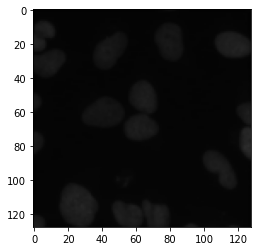

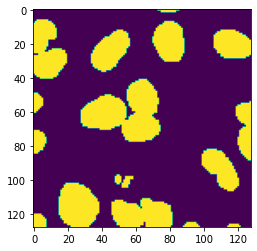

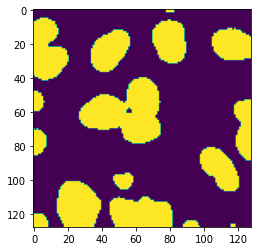

In [29]:
ix = np.random.randint(0, len(preds_train_t))
plt.imshow(X_train[ix])
plt.show()
plt.imshow(np.squeeze(Y_train[ix]))
plt.show()
plt.imshow(np.squeeze(preds_train_t[ix]))
plt.show()

## Transfer Learning using VGG16

In [4]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import Model

vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))
vgg_model.trainable = False

# we need to chop-off vgg at 'block1_conv2' to match the Y_train.shape
new_model = Model(inputs=vgg_model.input, outputs=vgg_model.get_layer('block1_conv2').output)
new_model.summary(), Y_train.shape[1:]

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
Total params: 38,720
Trainable params: 0
Non-trainable params: 38,720
_________________________________________________________________


(None, (128, 128, 1))

In [6]:
features = new_model.predict(X_train)
features.shape

(670, 128, 128, 64)

In [7]:
# For RF every pixel in every image is an instance with 64 features
X = features.reshape(-1, features.shape[-1])
Y = Y_train.reshape(-1)
print(X.shape, Y.shape)

from sklearn.model_selection import train_test_split
train_X, val_X, train_Y, val_Y = train_test_split(X, Y, test_size=0.2, random_state=42)

(10977280, 64) (10977280,)


In [31]:
train_Y.sum()/len(train_Y) * 100

20.048283818942398

### Logistic Regression

In [34]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter=10000)
lr.fit(train_X, train_Y)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score
print(f"Val accuracy = {accuracy_score(val_Y, lr.predict(val_X))}")
print(f"Val f1_score = {f1_score(val_Y, lr.predict(val_X))}")

Val accuracy = 0.9187581076550839
Val f1_score = 0.7765191144612354


### Random Forest

In [9]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(50, random_state=42, min_samples_split=2, n_jobs=-1)
rf.fit(train_X, train_Y)

RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=42)

In [10]:
from sklearn.metrics import accuracy_score, f1_score
print(f"Val accuracy = {accuracy_score(val_Y, rf.predict(val_X))}")
print(f"Val f1_score = {f1_score(val_Y, rf.predict(val_X))}")

Val accuracy = 0.9687240372842817
Val f1_score = 0.9218798885509922


### Neural Netwrok

### Test Prediction

In [11]:
X_test_features = new_model.predict(X_test)
X_test_features = X_test_features.reshape(-1, X_test_features.shape[-1])
preds_test = rf.predict(X_test_features)

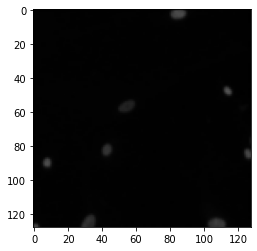

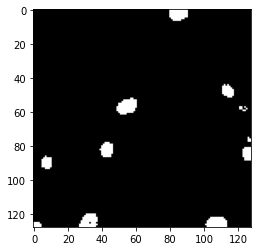

In [14]:
ix = np.random.randint(0, len(X_test))
plt.imshow(X_test[ix])
plt.show()
plt.imshow(np.squeeze(preds_test.reshape(len(X_test), IMG_WIDTH, IMG_HEIGHT)[ix]), cmap='gray')
plt.show()